In [35]:
# Time Series Sales Forecasting using ARIMA

In [36]:
## Objective
#The goal of this project is to forecast the next quarter (3 months) of sales
#using the ARIMA model based on historical monthly sales data.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error

plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

In [38]:
# Correct way to read your CSV

file_path = r"C:/Users/SATEESH/Downloads/monthly_sales.csv"

# 1) Inspect first few lines (optional but useful for debugging)
with open(file_path, "r") as f:
    for i in range(5):
        print(f.readline().strip())

date,sales
2013-01,14236.9
2013-02,4519.89
2013-03,55691.01
2013-04,28295.35


In [39]:
# 2) Read with header (since the first row is 'date,sales')
data = pd.read_csv(file_path)

# 3) Parse date with explicit format
# format='%Y-%m' because dates look like '2013-01'
data["date"] = pd.to_datetime(data["date"], format="%Y-%m")

# 4) Set date as index and enforce monthly frequency
data.set_index("date", inplace=True)
data = data.asfreq("MS")

data.head(), data.tail(), data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2013-01-01 to 2016-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


(               sales
 date                
 2013-01-01  14236.90
 2013-02-01   4519.89
 2013-03-01  55691.01
 2013-04-01  28295.35
 2013-05-01  23648.29,
                 sales
 date                 
 2016-08-01   63120.89
 2016-09-01   87866.65
 2016-10-01   77776.92
 2016-11-01  118447.83
 2016-12-01   83829.32,
 None)

In [20]:
# Cell 3: Basic summary
print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
display(data.head())

print("\nLast 5 rows:")
display(data.tail())

print("\nSummary statistics:")
display(data["sales"].describe())

Dataset shape: (48, 1)

First 5 rows:


,sales
date,
2013-01-01,14236.90
2013-02-01,4519.89
2013-03-01,55691.01
2013-04-01,28295.35
2013-05-01,23648.29



Last 5 rows:


,sales
date,
2016-08-01,63120.89
2016-09-01,87866.65
2016-10-01,77776.92
2016-11-01,118447.83
2016-12-01,83829.32



Summary statistics:


count        48.000000
mean      47858.351667
std       25221.124187
min        4519.890000
25%       29790.100000
50%       39339.515000
75%       65833.345000
max      118447.830000
Name: sales, dtype: float64

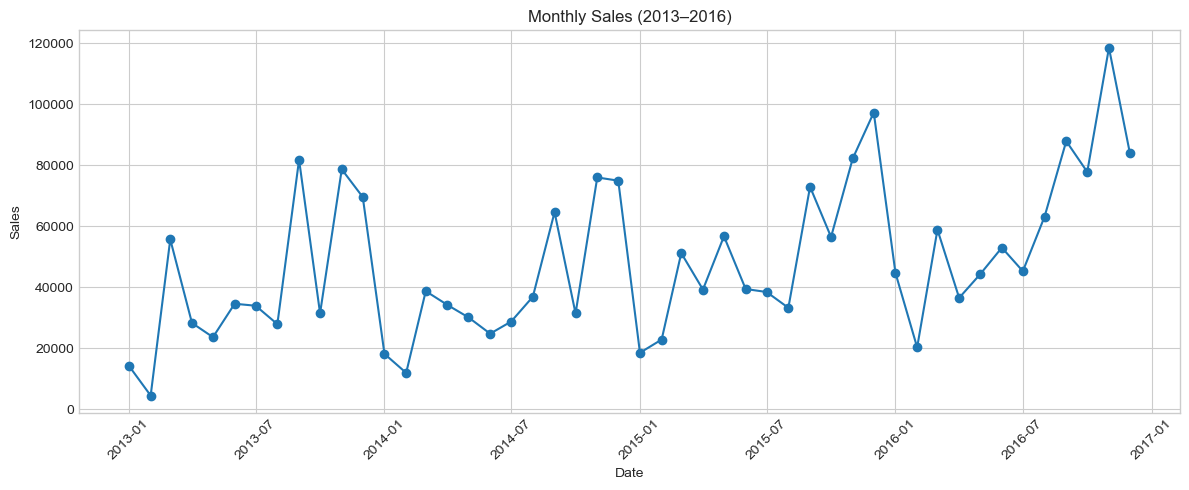

In [40]:
# Line plot of the full series
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["sales"], marker="o")
plt.title("Monthly Sales (2013–2016)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

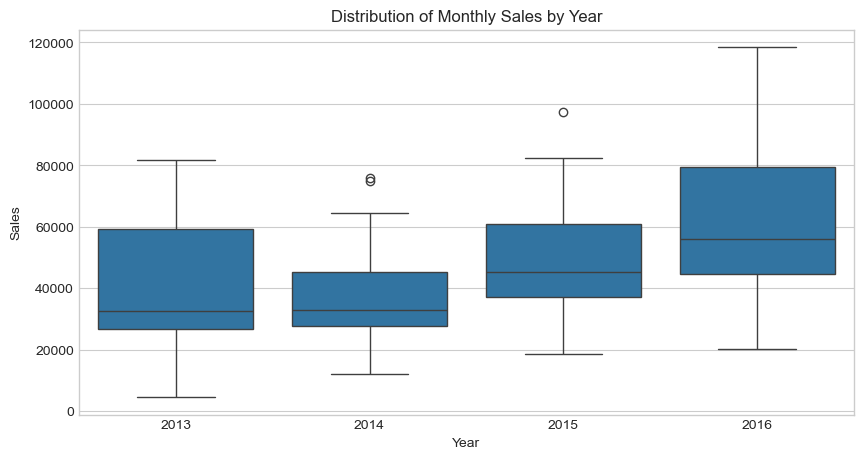

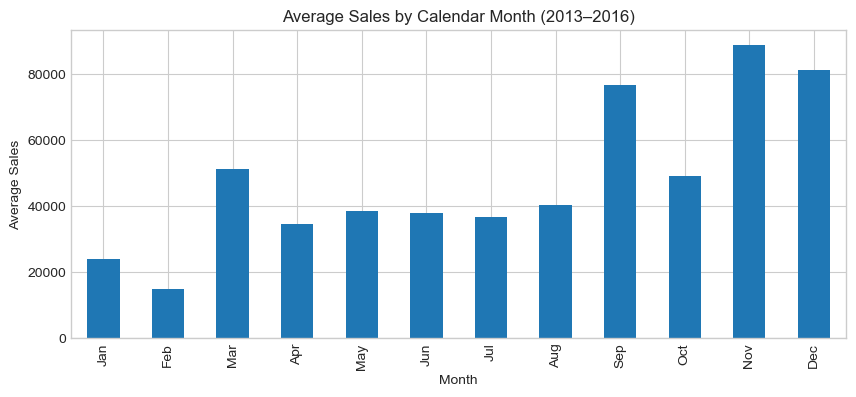

In [41]:
# Boxplot by year
data["year"] = data.index.year
data["month"] = data.index.month_name().str.slice(stop=3) 

plt.figure(figsize=(10, 5))
sns.boxplot(x="year", y="sales", data=data)
plt.title("Distribution of Monthly Sales by Year")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.show()

# Optional: seasonal pattern – average by month across years
monthly_avg = data.groupby("month")["sales"].mean()
# Order months correctly
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
monthly_avg = monthly_avg.reindex(month_order)

plt.figure(figsize=(10, 4))
monthly_avg.plot(kind="bar")
plt.title("Average Sales by Calendar Month (2013–2016)")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

# Drop helper columns to keep series clean for modeling
data = data[["sales"]]

In [42]:
# ADF test function
def adf_test(series, title=""):
    print(f"ADF Test: {title}")
    result = adfuller(series.dropna(), autolag="AIC")
    labels = ["ADF Statistic", "p-value", "# Lags Used", "# Observations Used"]
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> Reject H0: series is likely stationary")
    else:
        print("=> Fail to reject H0: series is likely NON-stationary")
    print("-" * 60)

adf_test(data["sales"], "Original Sales Series")

ADF Test: Original Sales Series
ADF Statistic           -4.481467
p-value                  0.000212
# Lags Used              0.000000
# Observations Used     47.000000
Critical Value (1%)     -3.577848
Critical Value (5%)     -2.925338
Critical Value (10%)    -2.600774
=> Reject H0: series is likely stationary
------------------------------------------------------------


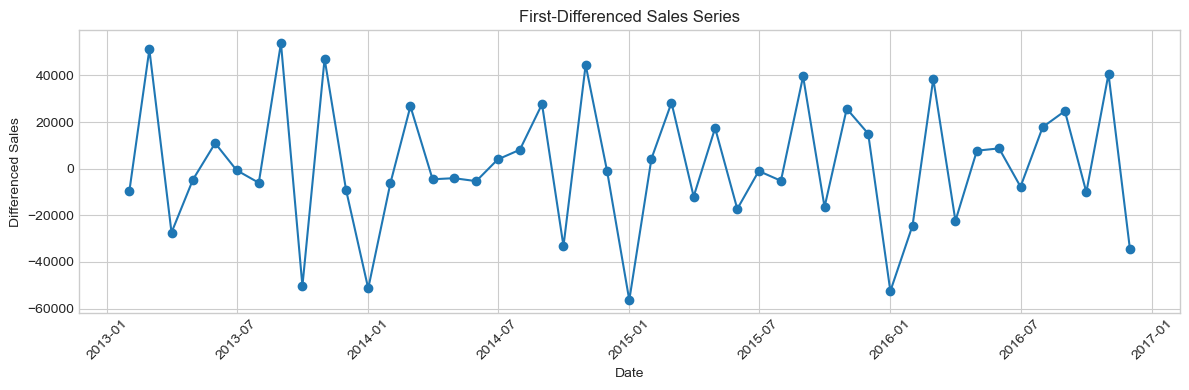

ADF Test: First Difference
ADF Statistic          -9.307052e+00
p-value                 1.073751e-15
# Lags Used             1.000000e+01
# Observations Used     3.600000e+01
Critical Value (1%)    -3.626652e+00
Critical Value (5%)    -2.945951e+00
Critical Value (10%)   -2.611671e+00
=> Reject H0: series is likely stationary
------------------------------------------------------------


In [43]:
# First difference
data_diff1 = data["sales"].diff()

plt.figure(figsize=(12, 4))
plt.plot(data_diff1, marker="o")
plt.title("First-Differenced Sales Series")
plt.xlabel("Date")
plt.ylabel("Differenced Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

adf_test(data_diff1, "First Difference")

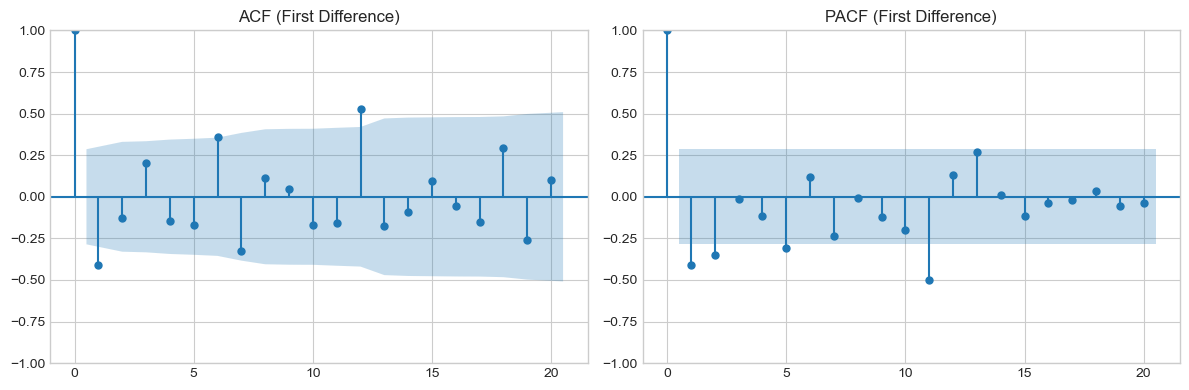

In [44]:
# ACF and PACF plots on differenced series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data_diff1.dropna(), ax=axes[0], lags=20)
axes[0].set_title("ACF (First Difference)")

plot_pacf(data_diff1.dropna(), ax=axes[1], lags=20, method="ywm")
axes[1].set_title("PACF (First Difference)")

plt.tight_layout()
plt.show()

In [45]:
# Train-test split
n_obs = len(data)
test_size = 6  
train, test = data.iloc[:-test_size], data.iloc[-test_size:]

print("Train start:", train.index[0], " - end:", train.index[-1], " (n=", len(train), ")")
print("Test  start:", test.index[0], " - end:", test.index[-1], " (n=", len(test), ")")

Train start: 2013-01-01 00:00:00  - end: 2016-06-01 00:00:00  (n= 42 )
Test  start: 2016-07-01 00:00:00  - end: 2016-12-01 00:00:00  (n= 6 )


In [46]:
# Simple manual grid search for (p, d, q) on training data
import warnings
warnings.filterwarnings("ignore")

p_values = [0, 1, 2]
d_values = [1]       
q_values = [0, 1, 2]

best_aic = np.inf
best_order = None
best_model = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                model = ARIMA(train["sales"], order=order)
                model_fit = model.fit()
                aic = model_fit.aic
                print(f"ARIMA{order} - AIC: {aic:.2f}")
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_model = model_fit
            except Exception as e:
                print(f"ARIMA{order} failed: {e}")

print("\nBest ARIMA order:", best_order, "with AIC:", best_aic)

ARIMA(0, 1, 0) - AIC: 957.55
ARIMA(0, 1, 1) - AIC: 944.64
ARIMA(0, 1, 2) - AIC: 945.28
ARIMA(1, 1, 0) - AIC: 952.48
ARIMA(1, 1, 1) - AIC: 945.79
ARIMA(1, 1, 2) - AIC: 947.19
ARIMA(2, 1, 0) - AIC: 948.79
ARIMA(2, 1, 1) - AIC: 947.38
ARIMA(2, 1, 2) - AIC: 949.15

Best ARIMA order: (0, 1, 1) with AIC: 944.6359303665881


In [47]:
# Forecast over the test period using the best model
print("Using best ARIMA order:", best_order)

# Forecast length = length of test set
n_test = len(test)
forecast_res = best_model.get_forecast(steps=n_test)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int(alpha=0.05)

# Align indices
forecast_mean.index = test.index
forecast_ci.index = test.index

# Combine into a DataFrame for convenience
results_df = pd.DataFrame({
    "actual": test["sales"],
    "forecast": forecast_mean
})
display(results_df)

Using best ARIMA order: (0, 1, 1)


,actual,forecast
date,,
2016-07-01,45264.42,49941.503659
2016-08-01,63120.89,49941.503659
2016-09-01,87866.65,49941.503659
2016-10-01,77776.92,49941.503659
2016-11-01,118447.83,49941.503659
2016-12-01,83829.32,49941.503659


In [48]:
# MAE and MAPE
mae = mean_absolute_error(results_df["actual"], results_df["forecast"])
mape = np.mean(np.abs((results_df["actual"] - results_df["forecast"]) / results_df["actual"])) * 100

print(f"MAE on test set: {mae:,.2f}")
print(f"MAPE on test set: {mape:,.2f}%")

MAE on test set: 31,001.86
MAPE on test set: 34.74%


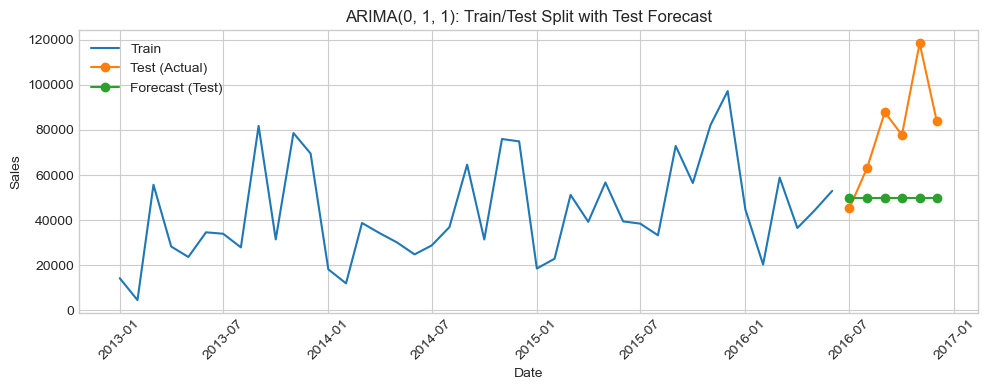

In [49]:
# Plot actual vs forecast on test set
plt.figure(figsize=(10, 4))
plt.plot(train.index, train["sales"], label="Train")
plt.plot(test.index, test["sales"], label="Test (Actual)", marker="o")
plt.plot(results_df.index, results_df["forecast"], label="Forecast (Test)", marker="o")

plt.title(f"ARIMA{best_order}: Train/Test Split with Test Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
# Refit on full dataset
final_model = ARIMA(data["sales"], order=best_order).fit()
print(final_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -540.340
Date:                Sat, 07 Feb 2026   AIC                           1084.679
Time:                        00:03:11   BIC                           1088.380
Sample:                    01-01-2013   HQIC                          1086.072
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6525      0.123     -5.314      0.000      -0.893      -0.412
sigma2      5.977e+08   1.04e-12   5.73e+20      0.000    5.98e+08    5.98e+08
Ljung-Box (L1) (Q):                   0.03   Jarque-

In [51]:
# 3‑month ahead forecast with 95% confidence intervals
n_steps = 3
final_forecast_res = final_model.get_forecast(steps=n_steps)
final_forecast_mean = final_forecast_res.predicted_mean
final_forecast_ci = final_forecast_res.conf_int(alpha=0.05)

print("Forecasted values for the next 3 months:")
display(pd.DataFrame({
    "forecast": final_forecast_mean,
    "lower_95": final_forecast_ci.iloc[:, 0],
    "upper_95": final_forecast_ci.iloc[:, 1]
}))

Forecasted values for the next 3 months:


,forecast,lower_95,upper_95
2017-01-01,85553.65964,37636.049737,133471.269544
2017-02-01,85553.65964,34824.646138,136282.673143
2017-03-01,85553.65964,32161.073236,138946.246045


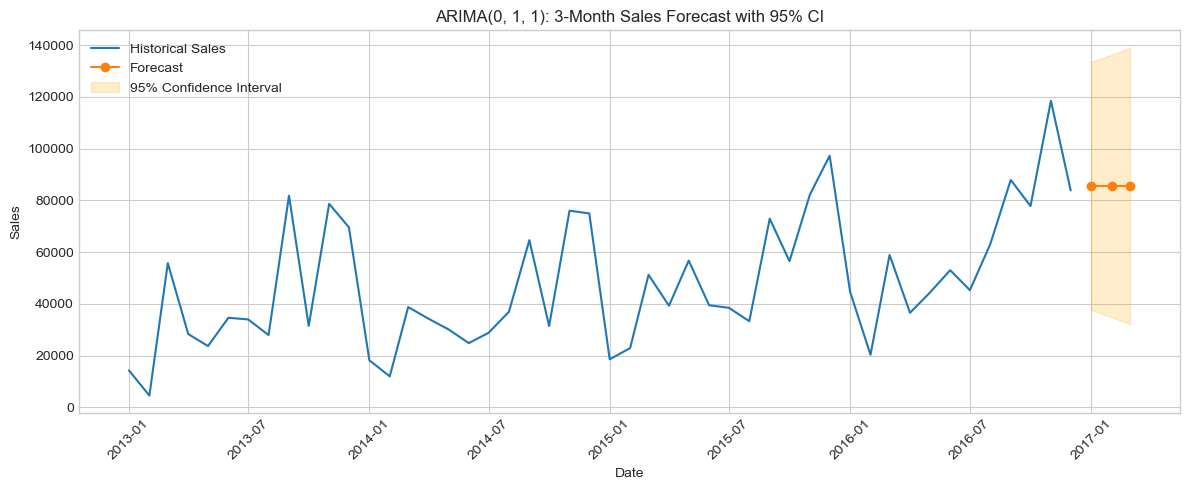

In [52]:
# Plot historical data and 3-month forecast
plt.figure(figsize=(12, 5))

# Plot historical data
plt.plot(data.index, data["sales"], label="Historical Sales")

# Plot forecast
future_index = final_forecast_mean.index
plt.plot(future_index, final_forecast_mean, label="Forecast", marker="o", color="tab:orange")

# Plot confidence intervals as shaded area
plt.fill_between(
    future_index,
    final_forecast_ci.iloc[:, 0],
    final_forecast_ci.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="95% Confidence Interval"
)

plt.title(f"ARIMA{best_order}: 3-Month Sales Forecast with 95% CI")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

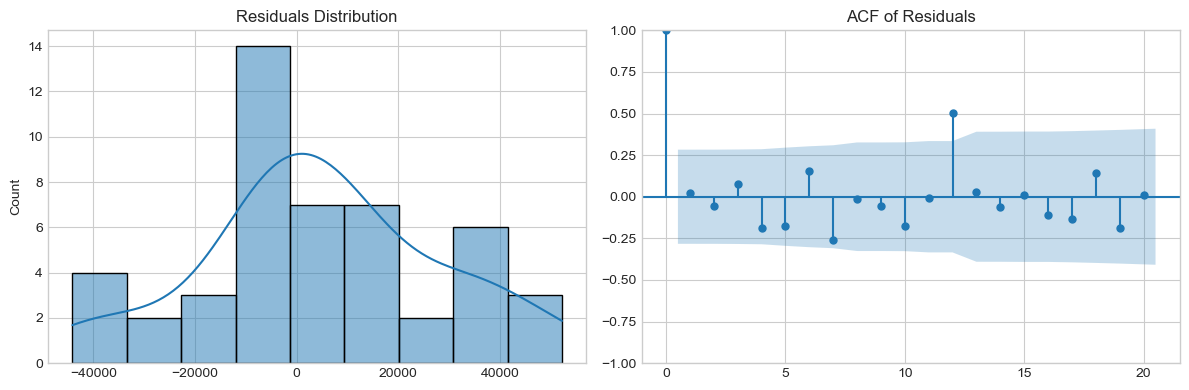

Residuals mean: 4883.701210035674
Residuals std: 23359.782373109712


In [53]:
# Residual diagnostics
residuals = final_model.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title("Residuals Distribution")

plot_acf(residuals, ax=axes[1], lags=20)
axes[1].set_title("ACF of Residuals")
plt.tight_layout()
plt.show()

print("Residuals mean:", residuals.mean())
print("Residuals std:", residuals.std())